# Expected coverage

This tutorial demonstrates how to apply the expected coverage diagnostic with LAMPE.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import zuko

from tqdm import tqdm

from lampe.data import JointLoader, H5Dataset
from lampe.diagnostics import expected_coverage_mc, expected_coverage_ni
from lampe.inference import NPE, NRE, FMPE, NPELoss, NRELoss, BNRELoss, FMPELoss
from lampe.plots import nice_rc, coverage_plot
from lampe.utils import GDStep

## Datasets

For this tutorial we use a toy simulator where $\theta$ parameterizes a 2-d multivariate Gaussian $\mathcal{N}(0, \operatorname{diag}(\theta^2))$ from which 4 points are independently drawn and stacked as a single observation $x$.

In [2]:
LOWER = -torch.ones(2)
UPPER = torch.ones(2)

prior = zuko.distributions.BoxUniform(LOWER, UPPER)

def simulator(theta: torch.Tensor) -> torch.Tensor:
    sigma = torch.abs(theta[..., None])
    mu = sigma.new_zeros(4)

    x = torch.normal(mu, sigma)

    return torch.flatten(x, -2)

theta = prior.sample()
x = simulator(theta)

print(theta, x, sep='\n')

tensor([0.5164, 0.2719])
tensor([ 0.3108, -0.2578, -0.5726,  0.4775, -0.4621,  0.0491,  0.2918,  0.0188])


We store (on disk) 4096 pairs $(\theta, x) \sim p(\theta, x)$ for training and 1024 pairs for testing.

In [3]:
loader = JointLoader(prior, simulator, batch_size=256, vectorized=True)

H5Dataset.store(loader, 'train.h5', size=4096, overwrite=True)
H5Dataset.store(loader, 'test.h5', size=1024, overwrite=True)

trainset = H5Dataset('train.h5', batch_size=256, shuffle=True)
testset = H5Dataset('test.h5')

  0%|          | 0/4096 [00:00<?, ?pair/s]

100%|██████████| 1024/1024 [00:00<00:00, 135227.71pair/s]


## Training

We train three different estimators: a neural posterior estimator (NPE), a neural ratio estimator (NRE) and a balanced neural ratio estimator (BNRE). For a fair comparison, we use the same training settings for all three.

In [4]:
npe = NPE(2, 8, hidden_features=[128] * 3, activation=nn.ELU)
nre = NRE(2, 8, hidden_features=[128] * 5, activation=nn.ELU)
bnre = NRE(2, 8, hidden_features=[128] * 5, activation=nn.ELU)
fmpe = FMPE(2, 8, hidden_features=[128] * 5, activation=nn.ELU)

In [5]:
def train(loss: nn.Module, epochs: int = 256) -> None:
    loss.cuda().train()

    optimizer = optim.AdamW(loss.parameters(), lr=1e-3)
    step = GDStep(optimizer, clip=1.0)

    with tqdm(range(epochs), unit='epoch') as tq:
        for epoch in tq:
            losses = torch.stack([
                step(loss(theta.cuda(), x.cuda()))
                for theta, x in trainset
            ])

            tq.set_postfix(loss=losses.mean().item())

    loss.eval()

train(NPELoss(npe))
train(NRELoss(nre))
train(BNRELoss(bnre))
train(FMPELoss(fmpe))

100%|██████████| 256/256 [00:22<00:00, 11.16epoch/s, loss=0.731]


## Expected coverage

Using the [`expected_coverage_mc`](lampe.diagnostics.expected_coverage_mc) and [`expected_coverage_ni`](lampe.diagnostics.expected_coverage_ni) functions provided by the [`lampe.diagnostics`](lampe.diagnostics) module, we estimate the respective expected coverage of the three estimators. The expected coverage at credible level $1 - \alpha$ is the probability of a set of parameters $\theta^*$ to fall inside the highest posterior density 

The expected coverage of a posterior estimator $q(\theta | x)$ at credible level $1 - \alpha$ is the probability of a set of parameters $\theta^*$ to be included in the highest density region of total probability $1 - \alpha$ of the posterior estimator, given an observation $x^* \sim p(x | \theta^*)$. If the estimator is callibrated, the expected coverage at credible level $1 - \alpha$ is exactly $1 - \alpha$. If it is overconfident, the highest density regions are smaller than they should be, which translates into lower coverages. If it is conservative/underconfident, the highest density regions are larger than they should be and the expected coverages are larger than their nominal level.

In [6]:
prior = zuko.distributions.BoxUniform(LOWER.cuda(), UPPER.cuda())

npe_levels, npe_coverages = expected_coverage_mc(npe.flow, testset, device='cuda')

log_p = lambda theta, x: nre(theta, x) + prior.log_prob(theta)  # log p(theta | x) = log r(theta, x) + log p(theta)
nre_levels, nre_coverages = expected_coverage_ni(log_p, testset, (LOWER, UPPER), device='cuda')

log_p = lambda theta, x: bnre(theta, x) + prior.log_prob(theta)
bnre_levels, bnre_coverages = expected_coverage_ni(log_p, testset, (LOWER, UPPER), device='cuda')

fmpe_levels, fmpe_coverages = expected_coverage_mc(fmpe.flow, testset, device='cuda')

  4%|▎         | 36/1024 [00:47<21:37,  1.31s/pair]


KeyboardInterrupt: 

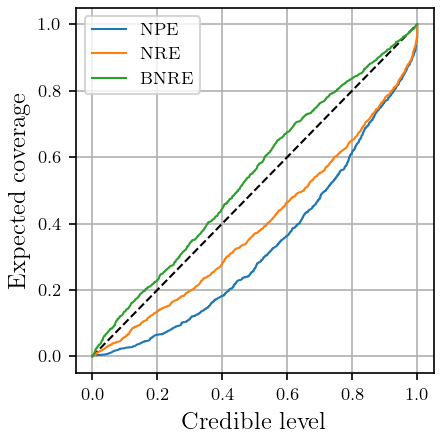

In [7]:
plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

fig = coverage_plot(npe_levels, npe_coverages, legend='NPE')
fig = coverage_plot(nre_levels, nre_coverages, legend='NRE', figure=fig)
fig = coverage_plot(bnre_levels, bnre_coverages, legend='BNRE', figure=fig)
# fig = coverage_plot(fmpe_levels, fmpe_coverages, legend='FMPE', figure=fig)

Here, we notice that NPE and NRE are overconfident while BNRE is almost callibrated.